# MLA Final Project

In [2]:
import numpy as np
from torch import nn
import torchani
import torch
import ANI1datatools.pyanitools as pya
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
%matplotlib inline

## Function to time code

In [3]:
from functools import wraps
from time import time
from tqdm import tqdm

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

## ANI network and Subnetwork

In [4]:
class ANI(nn.Module):
    def __init__(self):
        '''
        Class for ANN
        '''
        super(ANI, self).__init__()
        self.sub_nets = nn.ModuleDict({"0": ANI_sub(nn.Sequential(
                                                    nn.Linear(384,64),
                                                    nn.CELU(0.1),
                                                    nn.Linear(64, 64),
                                                    nn.CELU(0.1),
                                                    nn.Linear(64, 32),
                                                    nn.CELU(0.1),
                                                    nn.Linear(32, 1)
                                                )), 
                                       "1": ANI_sub(nn.Sequential(
                                                    nn.Linear(384,64),
                                                    nn.CELU(0.1),
                                                    nn.Linear(64, 64),
                                                    nn.CELU(0.1),
                                                    nn.Linear(64, 32),
                                                    nn.CELU(0.1),
                                                    nn.Linear(32, 1)
                                                )),                                         
                                       "2": ANI_sub(nn.Sequential(
                                                    nn.Linear(384,64),
                                                    nn.CELU(0.1),
                                                    nn.Linear(64, 64),
                                                    nn.CELU(0.1),
                                                    nn.Linear(64, 32),
                                                    nn.CELU(0.1),
                                                    nn.Linear(32, 1)
                                                )), 
                                       "3": ANI_sub(nn.Sequential(
                                                    nn.Linear(384,64),
                                                    nn.CELU(0.1),
                                                    nn.Linear(64, 64),
                                                    nn.CELU(0.1),
                                                    nn.Linear(64, 32),
                                                    nn.CELU(0.1),
                                                    nn.Linear(32, 1)
                                                ))})

    def forward(self, aevs, molecule_atoms, device):
        '''
        Forward function of the main ANN
        
        input:
            aevs: a tensor of aevs with the shape (# conformations in batch, # atoms, 384)
            molecule_atoms: a tensor containing atom species information with the shape (# conformations in batch, # atoms)
            device: CUDA device variable
        
        output:
            batch_predictions: a tensor containing total potential energy predictions with the shape (# conformations in batch)
        '''
        # Flatten the molecules passed in and the aevs
        molecule_atoms_flat = molecule_atoms.flatten()
        aevs = aevs.flatten(0, 1)
    
        # Create output vector
        output = aevs.new_zeros(molecule_atoms_flat.shape)
        
        # Key matches i, since the dictionary above is built based on "0", "1", "2", "3" which correspond to H, C, N, O, respectively.
        # But since Key is a string i is used to find matches with the molecule atoms passed in to create a mask
        # Since we are looping through the sub models above, we dont need to pass in the key for the model, we can just access the model since we enumerated
        for i, (key, model) in enumerate(self.sub_nets.items()):
            # creating a mask where we get True or False if the atom is equal to the model we want to train on
            mask = (molecule_atoms_flat == i)
            
            # getting the indices for the atoms that need to go to the current model model
            atom_indices = mask.nonzero().flatten()
            
            # Only train on the model, if we have indices for the atom type (ie. if the atom doesnt exist in this batch, then pass)
            if atom_indices.shape[0] > 0:
                # get the indices from the aev_input that will need to train on the atom model
                aev_input = aevs.index_select(0, atom_indices)
                
                # add the output from model(aev_input) into the output tensor where "mask" is true.
                output.masked_scatter_(mask, model(aev_input).flatten())
        
        # convert the output to the same shape as molecule_atoms
        output = output.view_as(molecule_atoms)
        return torch.sum(output, dim=1)

class ANI_sub(nn.Module):
    def __init__(self, architecture):
        super(ANI_sub, self).__init__()
        self.layers = architecture

    def forward(self, aev):
        '''
        Forward function of the ANI_Sub
        
        input:
            aevs: a tensor of aevs with the shape (# conformations in batch, 384)
        
        output:
            atomic_energy: a tensor containing the total potential energy prediction for a specific atom type with the shape (# conformations in batch)
        '''
        atomic_energy = self.layers(aev)
        return atomic_energy


## Trainer class and generator to train the model.

In [5]:
from torch.optim import SGD, Adam
from torch import nn
import torch
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, device):
        """ 
        The class for training the model
        
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: learning rate to train model as float
        epoch: number of epochs to train as int
        batch_size: size of each batch to train ont as int
        device: CUDA device variable
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
        
        self.lr = learning_rate
        self.epoch = epoch
        self.batch_size = batch_size
        self.device = device

    def train(self, inputs, val_inputs, aev_computer, draw_curve=True, early_stop=False,l2=False,silent=False):
        """ 
        Train self.model with specified arguments
        
        Input:
            inputs: list of dictionaries with shape where each batch is a dictionary containing the keys "species",
                    "coordinates", and "energies" whose value pairs are stacked tensors.
            val_inputs: list of dictionaries with shape where each batch is a dictionary containing the keys "species",
                    "coordinates", and "energies".
            aev_computer: AEVcomputer object from torchANI module.
            draw_curve: bool
            early_stop: bool
            l2: bool
            silent: bool. Controls whether or not to print the train and val error during training
        
        Outputs:
            a dictionary of arrays with train and val losses and accuracies
        """
                
        losses = []
        val_losses = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        loss_func = nn.MSELoss()
        
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            epoch_loss = 0
            total=0
            
            # Calculate total conformations in the training set for batch_importance
            for mol in inputs:
                total += len(mol) 
                
            for mol in inputs:
                batch_importance = len(mol) / total
                
                # Select the species, coordinates and energies for the batch and place them on CUDA if available.
                species = mol['species'].to(self.device)
                coordinates = mol['coordinates'].to(self.device).float()
                energies = mol['energies'].to(self.device).float()

                # Compute AEV
                aev = aev_computer((species, coordinates))
                
                aevs = aev[1]
                
                # Train model and get predictions.
                predictions = self.model(aevs, species, self.device)

                # Calculate MSELoss here by converting to kcal/mol first.
                loss = loss_func(predictions*627.5, energies*627.5) 
                
                # Regularization if necessary
                if l2:
                    ### Compute the loss with L2 regularization ###
                    l2_norm = sum([p.pow(2.0).sum() for p in self.model.parameters()])
                    loss = loss + 0.00001 * l2_norm
                    #lambda is 1e-5 == 0.00001

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                ### Compute epoch_loss 
                epoch_loss += np.sqrt(loss.detach().item()) * batch_importance
                
            # Compute validaiton loss
            val_loss = self.evaluate(val_inputs, aev_computer)
            
            if n_epoch % 10 ==0 and not silent:
                print("Epoch %d/%d - Loss: %.3f" % (n_epoch + 1, self.epoch, epoch_loss))
                print("              Val_loss: %.3f" % (val_loss))
                print("              Batch_size: %.3f" % (self.batch_size))
                
            # Append losses to trach loss over epochs
            losses.append(epoch_loss)
            val_losses.append(val_loss)

            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
        
        # Draw graph of epochs vs training and validation losses
        if draw_curve:
            plt.figure()
            plt.plot(np.arange(self.epoch) + 1, losses,label='Training loss')
            plt.plot(np.arange(self.epoch) + 1, val_losses,label='Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            
        if early_stop:
            self.model.load_state_dict(weights)    
        
        return {"losses": losses, "val_losses": val_losses}
        
    def evaluate(self, inputs, aev_computer, print_loss=False):
        """ 
        Evaluate self.model with specified arguments
        
        Input:
            inputs: list of dictionaries with shape where each batch is a dictionary containing the keys "species",
                    "coordinates", and "energies" whose value pairs are stacked tensors.
            aev_computer: AEVcomputer object from torchANI module.
            print_loss: bool
        
        Outputs:
            losses: validation loss for the current epoch
        """        
        loss_func = nn.MSELoss()
        
        self.model.eval()
        losses=0
        total=0
        
        # Calculate total conformations in the training set for batch_importance
        for mol in inputs:
            total += len(mol) 
            
        for mol in inputs:
            batch_importance = len(mol) / total
            with torch.no_grad():
                
                # Select the species, coordinates and energies for the batch and place them on CUDA if available.
                species = mol['species'].to(self.device)
                coordinates = mol['coordinates'].to(self.device).float()
                energies = mol['energies'].to(self.device).float()
                
                # Compute AEV
                aev = aev_computer((species, coordinates))
                
                aevs = aev[1]
                
                # Train model and get predictions.
                predictions = self.model(aevs, species, self.device)

                # Calculate MSELoss here by converting to kcal/mol first.
                loss = loss_func(predictions*627.5, energies*627.5) 

                # Compute epoch_loss 
                losses += np.sqrt(loss.detach().item()) * batch_importance
                
        if print_loss:
            print("Val Loss: %.3f" % losses, "Batch size: %.3f" % self.batch_size)
        return losses

## Trainer function to train the molecule and create cuda device variable.

In [6]:
@timing
def new_molecule_train(model, inputs, val_inputs, lr, epochs, batch_size, frequency=1):
    """ 
        Create a model setup and train it using the Trainer class.
        
        Input:
            inputs: list of dictionaries with shape where each batch is a dictionary containing the keys "species",
                    "coordinates", and "energies" whose value pairs are stacked tensors.
            val_inputs: list of dictionaries with shape where each batch is a dictionary containing the keys "species",
                    "coordinates", and "energies".
            model: nn.Module
                A pytorch model
            lr: learning rate to train model as float
            epochs: number of epochs to train as int
            batch_size: size of each batch to train ont as int
        
        Outputs:
            Training and Validation losses as a dictionary from the .train() method of the Trainer class.
    """        
    # Instantiate CUDA device if available
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(device)
    
    # Create model instance
    model_instance = model
    
    # Send model to device
    model_instance.to(device)
    
    # Create Trainer object using inputs passed in
    ANI_trainer = Trainer(model_instance, "adam", lr, epochs, batch_size, device)
    
    # Create aev computer object from torchANI.
    Rcr = 5.2
    EtaR = torch.tensor([16], dtype=torch.float).to(device)
    ShfR = torch.tensor([0.900000,1.168750,1.437500,1.706250,1.975000,2.243750,2.51250,2.781250,3.050000, 3.318750,3.587500,3.856250,4.125000,4.39375,4.662500,4.931250], dtype=torch.float).to(device)

    Rca = 3.5
    EtaA = torch.tensor([8], dtype=torch.float).to(device)
    ShfA = torch.tensor([0.900000,1.550000,2.200000,2.850000], dtype=torch.float).to(device)
    ShfZ = torch.tensor([0.19634954,0.58904862,0.9817477,1.3744468,1.7671459,2.1598449,2.552544,2.945243], dtype=torch.float).to(device)
    Zeta = torch.tensor([32], dtype=torch.float).to(device)
    species_order = ['H', 'C', 'N', 'O']
    num_species = len(species_order)
    aev_computer = torchani.AEVComputer(Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species)

    draw_curve_bool=True 
    early_stop_bool=False
    l2_bool=False
    silent_bool=True
    
    return ANI_trainer.train(inputs, val_inputs, aev_computer, draw_curve=draw_curve_bool, early_stop=early_stop_bool, l2=l2_bool, silent=silent_bool)

## Function to fetch data and create preliminary model input

In [7]:
def get_data(list_files):
    '''
    input: 
        list_files: list strings of h5file names
    Output: 
        data_set: Species and coordinates of each file as a np.array of list of dictionaries, and the y_energies associated as a list.
    '''
    mapping={"H":0, "C":1, "N":2, "O":3}
    data_set = []
    
    self_interaction_energies = {0:-0.500607632585, 1:-37.8302333826, 2:-54.5680045287, 3:-75.0362229210}
    
    # Loop through the file names
    for i in list_files:
        hdf5file = i
        print(i)
        # Construct the data loader class
        data = pya.anidataloader(hdf5file)
        data_iter = data.__iter__()
        for mol in data_iter:
            # convert species from string to integer
            species = np.array([mapping[atom] for atom in mol['species']])
            
            # calculate how self energy to subtract for each conformation based on the molecule species
            energy_to_subtract = sum([self_interaction_energies[atom] for atom in species])  
            
            # loop through all conformations for a specific molecule and organize the data in the output format and subtract self energies
            for conformation in range(len(mol['energies'])):
                data_set.append({'species': torch.tensor(species), 'coordinates': torch.tensor(mol['coordinates'][conformation]), 'energies': mol['energies'][conformation] - energy_to_subtract})
                
    return np.array(data_set)

In [35]:
data = get_data(["ANI-1_release/ani_gdb_s01.h5", "ANI-1_release/ani_gdb_s02.h5"])

ANI-1_release/ani_gdb_s01.h5
ANI-1_release/ani_gdb_s02.h5


/global/homes/j/jamshedu/.local/perlmutter/pytorch1.9.0/lib/python3.8/site-packages/ANI1datatools/pyanitools.py:48: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.store = h5py.File(store_file)


## Splitting data into training, testing and validaiton sets

In [36]:
# Peform train_test_split on the data to get training, testing and validation sets
train, test = train_test_split(data, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.1, random_state=42)

## Function to create final model input with the correct molecular representation and stacking

In [8]:
def create_model_input(data, batch_size):
    """ 
        Create a model setup and train it using the Trainer class.
        
        Input:
            data: Species and coordinates of each file as a np.array of list of dictionaries, 
                and the y_energies associated as a list.
            batch_size: size of each batch to train on as int
        
        Outputs:
            model_input: DataLoader object with the correct model input shape and batches based on batch_size
    """
    # Get all the data for each of species, coordinates, and energies
    list_of_species_tensors = [i['species'] for i in data]
    list_of_coordinate_tensors = [i['coordinates'] for i in data]
    tensor_of_energies = torch.tensor([i['energies'] for i in data])
    
    # Padding tensors with -1 for atoms and 0s for coordinates
    padded_species_tensors = pad_sequence(list_of_species_tensors, batch_first=True, padding_value = -1)
    padded_coordinate_tensors = pad_sequence(list_of_coordinate_tensors, batch_first=True, padding_value = 0.0)
    
    # create into list of dictionaries with batches
    # [{species: [tensor of size batch], coordinates: [tensor of size batch], energies: [tensor of size batch]}, {...}, {...}]
    padded_data = []
    for i in range(len(tensor_of_energies)):
        padded_data.append({'species': padded_species_tensors[i], 'coordinates': padded_coordinate_tensors[i], 'energies': tensor_of_energies[i]})
        
    # Creating a data loader using pytorch to make final model input
    model_input = torch.utils.data.DataLoader(padded_data, batch_size=batch_size)
    return model_input

In [10]:
training = create_model_input(train, 2560)
validation = create_model_input(val, 2560)
testing = create_model_input(test, 2560)

## Preliminary testing 

cuda:0


  0%|          | 0/1000 [00:00<?, ?it/s]/global/common/software/nersc/shasta2105/pytorch/1.9.0/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:461.)
  return torch.floor_divide(self, other)
                                                   

func:'new_molecule_train'  took: 339.3896 sec


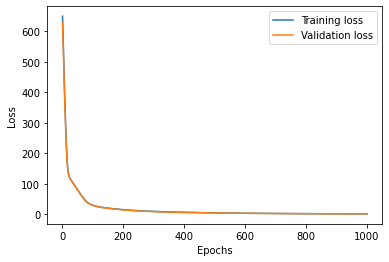

In [12]:
testing = new_molecule_train(ANI(), training, validation, 2e-5, 1000, 2560)

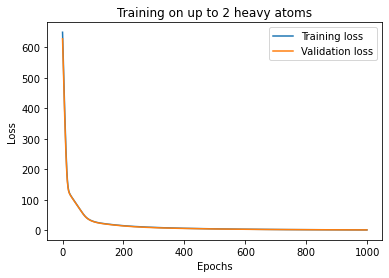

In [13]:
plt.figure()
plt.plot(testing['losses'], label='Training loss')
plt.plot(testing['val_losses'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 2 heavy atoms')
plt.savefig('2ha_2560_1000_2e5.png')

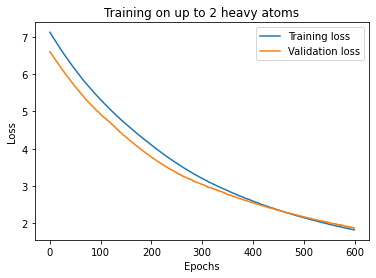

In [14]:
plt.figure()
plt.plot(testing['losses'][400:], label='Training loss')
plt.plot(testing['val_losses'][400:], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 2 heavy atoms')
plt.savefig('2ha_2560_600_2e5_zoomed.png')

# Hyperparameter Tuning

## Training on all molecules from data sets s01, s02

## Investigating how LR effects the training loss and validation loss

cuda:0


func:'new_molecule_train'  took: 328.3206 sec


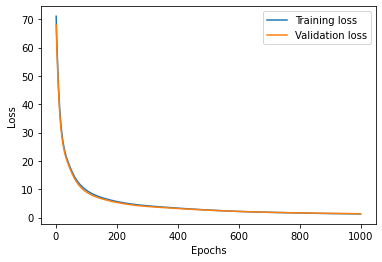

In [15]:
e_five = new_molecule_train(ANI(), training, validation, 2e-5, 1000, 2560)

cuda:0


func:'new_molecule_train'  took: 347.2264 sec


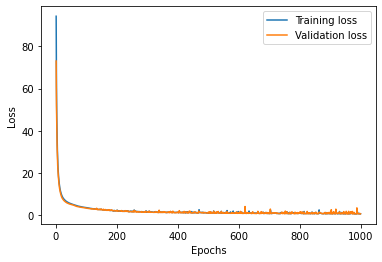

In [16]:
e_four = new_molecule_train(ANI(), training, validation, 2e-4, 1000, 2560)

cuda:0


func:'new_molecule_train'  took: 331.9079 sec


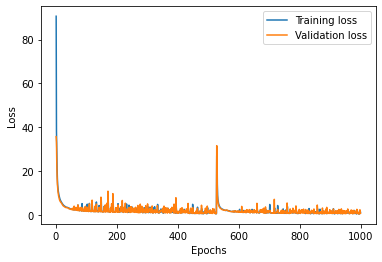

In [17]:
e_three = new_molecule_train(ANI(), training, validation, 2e-3, 1000, 2560)

cuda:0


func:'new_molecule_train'  took: 328.1334 sec


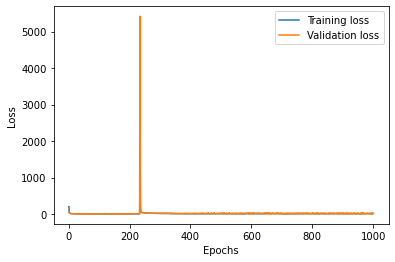

In [18]:
e_two = new_molecule_train(ANI(), training, validation, 2e-2, 1000, 2560)

cuda:0


func:'new_molecule_train'  took: 327.0459 sec


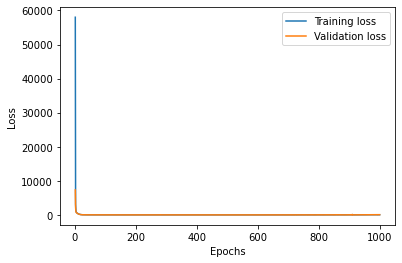

In [19]:
e_one = new_molecule_train(ANI(), training, validation, 2e-1, 1000, 2560)

## Taking a closer look at the later epochs to see how the losses are changing

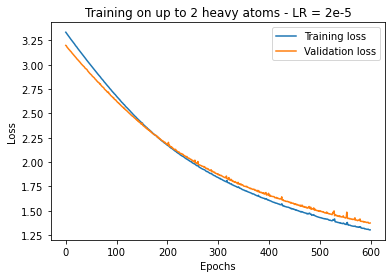

In [20]:
plt.figure()
plt.plot(e_five['losses'][400:], label='Training loss')
plt.plot(e_five['val_losses'][400:], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 2 heavy atoms - LR = 2e-5')
plt.savefig('2ha_2560_600_2e5_zoomed2.png')

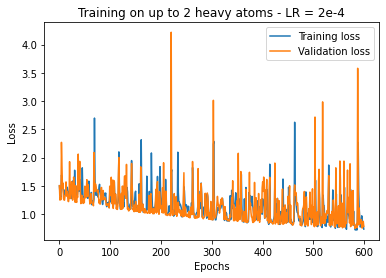

In [21]:
plt.figure()
plt.plot(e_four['losses'][400:], label='Training loss')
plt.plot(e_four['val_losses'][400:], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 2 heavy atoms - LR = 2e-4')
plt.savefig('2ha_2560_600_2e4_zoomed.png')

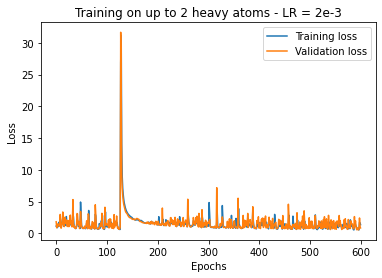

In [22]:
plt.figure()
plt.plot(e_three['losses'][400:], label='Training loss')
plt.plot(e_three['val_losses'][400:], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 2 heavy atoms - LR = 2e-3')
plt.savefig('2ha_2560_600_2e3_zoomed.png')

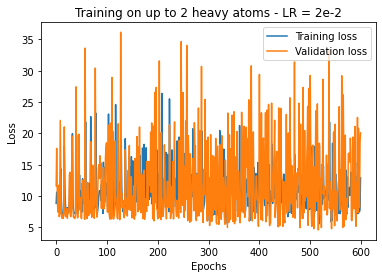

In [23]:
plt.figure()
plt.plot(e_two['losses'][400:], label='Training loss')
plt.plot(e_two['val_losses'][400:], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 2 heavy atoms - LR = 2e-2')
plt.savefig('2ha_2560_600_2e2_zoomed.png')

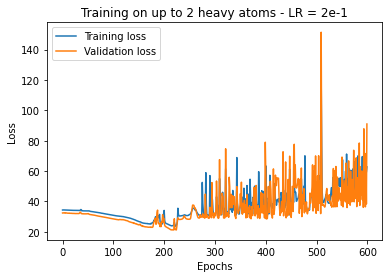

In [24]:
plt.figure()
plt.plot(e_one['losses'][400:], label='Training loss')
plt.plot(e_one['val_losses'][400:], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 2 heavy atoms - LR = 2e-1')
plt.savefig('2ha_2560_600_2e1_zoomed.png')

## As shown by the different LR, we want to have a large learning rate so that we can minimize the error in a short amount of epochs, however if the learning rate is too large (ex, 2e-1, 2e-2, 2e-3) then the model has a hard time learning and minimizing error with the error exploding again near the end of the epochs. On the contrary, if the learning rate is too low, then the model takes a very long time to train and the error is still quite large at the end of the epochs (ex, 2-e5). The best learning rate I have found which is a happy medium between training slowly as well as minizming error in a reasonable number of epochs is 2e-4 with the smoothest curves at 2e-5. The best solution however, would be to create a scheduler which would reduce the learning rate when the training starts to plateau.

## Creating new trainer class to hold a LR scheduler

In [9]:
from torch.optim import lr_scheduler
class Trainer_scheduler():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, device):
        """ 
        The class for training the model with a scheduler
        
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: learning rate to train model as float
        epoch: number of epochs to train as int
        batch_size: size of each batch to train ont as int
        device: CUDA device variable
        """
        self.model = model
        
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
            self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=5, min_lr=3e-6)

        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
            self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=5, min_lr=3e-6)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.device = device

    def train(self, inputs, val_inputs, aev_computer, draw_curve=True, early_stop=False,l2=False,silent=False):
        """ 
        Train self.model with specified arguments
        
        Input:
            inputs: list of dictionaries with shape where each batch is a dictionary containing the keys "species",
                    "coordinates", and "energies" whose value pairs are stacked tensors.
            val_inputs: list of dictionaries with shape where each batch is a dictionary containing the keys "species",
                    "coordinates", and "energies".
            aev_computer: AEVcomputer object from torchANI module.
            draw_curve: bool
            early_stop: bool
            l2: bool
            silent: bool. Controls whether or not to print the train and val error during training
        
        Outputs:
            a dictionary of arrays with train and val losses and accuracies
        """
                
        losses = []
        val_losses = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        loss_func = nn.MSELoss()
        
        total=0
        # Calculate total conformations in the training set for batch_importance
        for mol in inputs:
            total += len(mol)
            
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            epoch_loss = 0
            for mol in inputs:
                batch_importance = len(mol) / total
                
                # Grab the species, coordinates and energies tensors for the current batch and place them on the device
                species = mol['species'].to(self.device)
                coordinates = mol['coordinates'].to(self.device).float()
                energies = mol['energies'].to(self.device).float()
                
                # Compute AEV for current batch
                aev = aev_computer((species, coordinates))
                
                aevs = aev[1]
                
                # Train model and calculate predictions on current batch
                predictions = self.model(aevs, species, self.device)

                # Calculate MSELoss after converting to kcal/mol.
                loss = loss_func(predictions*627.5, energies*627.5) 

                # Regularization if necessary
                if l2:
                    ### Compute the loss with L2 regularization ###
                    l2_norm = sum([p.pow(2.0).sum() for p in self.model.parameters()])
                    loss = loss + 0.00001 * l2_norm
                    #lambda is 1e-5 == 0.00001

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                ### Compute epoch_loss 
                epoch_loss += np.sqrt(loss.detach().item()) * batch_importance
            
            # Scheduler step based on loss
            self.scheduler.step(epoch_loss)
    
            # Calculate validation loss
            val_loss = self.evaluate(val_inputs, aev_computer)
            
            if n_epoch % 10 ==0 and not silent:
                print("Epoch %d/%d - Loss: %.3f" % (n_epoch + 1, self.epoch, epoch_loss))
                print("              Val_loss: %.3f" % (val_loss))
                print("              Batch_size: %.3f" % (self.batch_size))
                
            # Append losses to lists to see how training and validation loss change over time.    
            losses.append(epoch_loss)
            val_losses.append(val_loss)

            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
                    
        # Graph epochs vs training and validation loss
        if draw_curve:
            plt.figure()
            plt.plot(np.arange(self.epoch) + 1, losses,label='Training loss')
            plt.plot(np.arange(self.epoch) + 1, val_losses,label='Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
        
        if early_stop:
            self.model.load_state_dict(weights)    
        
        return {"losses": losses, "val_losses": val_losses}, self.model
        
    def evaluate(self, inputs, aev_computer, print_loss=False):
        """ 
        Evaluate self.model with specified arguments
        
        Input:
            inputs: list of dictionaries with shape where each batch is a dictionary containing the keys "species",
                    "coordinates", and "energies" whose value pairs are stacked tensors.
            aev_computer: AEVcomputer object from torchANI module.
            print_loss: bool
        
        Outputs:
            losses: validation loss for the current epoch
        """       
        loss_func = nn.MSELoss()
        
        self.model.eval()
        losses=0
        total=0
        
        # Calculate total length of conformations in the batches to use in batch_importance
        for mol in inputs:
            total += len(mol)
            
        for mol in inputs:
            batch_importance = len(mol) / total
            with torch.no_grad():
                
                # Grab the species, coordinates and energies tensors for the current batch and place them on the device
                species = mol['species'].to(self.device)
                coordinates = mol['coordinates'].to(self.device).float()
                energies = mol['energies'].to(self.device).float()
                
                # Compute AEVs for the current batch
                aev = aev_computer((species, coordinates))
                
                aevs = aev[1]
                
                # Train and predict on the current batch
                predictions = self.model(aevs, species, self.device)

                # Compute MSELoss and convert to kcal/mol before computing
                loss = loss_func(predictions*627.5, energies*627.5) 

                ### Compute epoch_loss 
                losses += np.sqrt(loss.detach().item()) * batch_importance
                
        if print_loss:
            print("Val Loss: %.3f" % losses, "Batch size: %.3f" % self.batch_size)
        return losses

## New molecule trainer function which functions based on the scheduler

In [10]:
@timing
def new_molecule_train_schedule(model, inputs, val_inputs, test_inputs, lr, l2, epochs, batch_size, frequency=1):
    """ 
        Create a model setup and train it using the Trainer class.
        
        Input:
            inputs: list of dictionaries with shape where each batch is a dictionary containing the keys "species",
                    "coordinates", and "energies" whose value pairs are stacked tensors.
            val_inputs: list of dictionaries with shape where each batch is a dictionary containing the keys "species",
                    "coordinates", and "energies".
            model: nn.Module
                A pytorch model
            lr: learning rate to train model as float
            l2: regularization as a bool
            epochs: number of epochs to train as int
            batch_size: size of each batch to train ont as int
        
        Outputs:
            loss_log: Training and Validation error log over all epochs.
            test_log: Testing error log over all epochs.
            final_model: Output of final trained model.
    """        
    # Instantiate CUDA device if available
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(device)
    
    # Create Model instance
    model_instance = model
    
    # Place model on the device
    model_instance.to(device)
    
    # Create trainer object using the specified arguments
    ANI_trainer = Trainer_scheduler(model_instance, "adam", lr, epochs, batch_size, device)
    
    # Create AEVcomputer object
    Rcr = 5.2
    EtaR = torch.tensor([16], dtype=torch.float).to(device)
    ShfR = torch.tensor([0.900000,1.168750,1.437500,1.706250,1.975000,2.243750,2.51250,2.781250,3.050000, 3.318750,3.587500,3.856250,4.125000,4.39375,4.662500,4.931250], dtype=torch.float).to(device)

    Rca = 3.5
    EtaA = torch.tensor([8], dtype=torch.float).to(device)
    ShfA = torch.tensor([0.900000,1.550000,2.200000,2.850000], dtype=torch.float).to(device)
    ShfZ = torch.tensor([0.19634954,0.58904862,0.9817477,1.3744468,1.7671459,2.1598449,2.552544,2.945243], dtype=torch.float).to(device)
    Zeta = torch.tensor([32], dtype=torch.float).to(device)
    species_order = ['H', 'C', 'N', 'O']
    num_species = len(species_order)
    aev_computer = torchani.AEVComputer(Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species)

    draw_curve_bool=True 
    early_stop_bool=False
    l2_bool=l2
    silent_bool=True
    
    # Train model using Trainer object and method train
    loss_log, final_model = ANI_trainer.train(inputs, val_inputs, aev_computer, draw_curve=draw_curve_bool, early_stop=early_stop_bool, l2=l2_bool, silent=silent_bool)
    # Evaluate model using Trainer object and method evaluate
    test_log = ANI_trainer.evaluate(test_inputs, aev_computer)
    
    return loss_log, test_log, final_model

## Implementing a scheduler starting with a learning rate of 2e-3, 2e-4. (2e-5 is not included because it does not show any issues that the larger LR show)

In [39]:
training = create_model_input(train, 2560)
validation = create_model_input(val, 2560)
testing = create_model_input(test, 2560)

cuda:0


func:'new_molecule_train_schedule'  took: 320.5145 sec


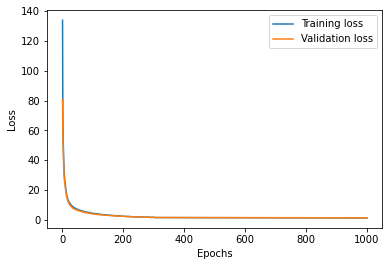

In [41]:
e_four_scheduler_loss, efs_test_loss, efs_model = new_molecule_train_schedule(ANI(), training, validation, testing, 2e-4, False, 1000, 2560)

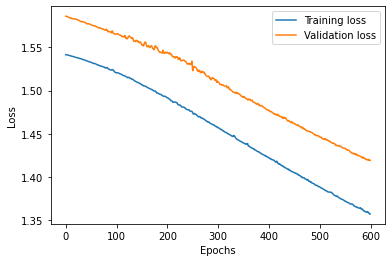

In [42]:
plt.figure()
plt.plot(e_four_scheduler_loss['losses'][400:], label='Training loss')
plt.plot(e_four_scheduler_loss['val_losses'][400:], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

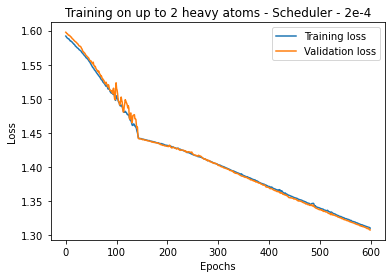

In [32]:
plt.figure()
plt.plot(e_four_scheduler['losses'][400:], label='Training loss')
plt.plot(e_four_scheduler['val_losses'][400:], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 2 heavy atoms - Scheduler - 2e-4')
plt.savefig('2ha_2560_600_2e4_scheduler_zoomed.png')

cuda:0


  0%|          | 0/1000 [00:00<?, ?it/s]/global/common/software/nersc/shasta2105/pytorch/1.9.0/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:461.)
  return torch.floor_divide(self, other)
                                                   

func:'new_molecule_train_schedule'  took: 350.6610 sec


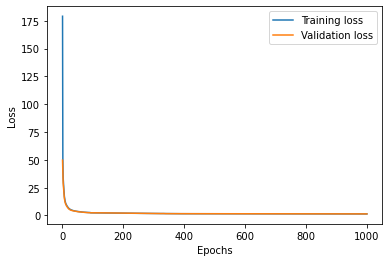

In [18]:
e_three_scheduler_loss, ets_test_loss, ets_model = new_molecule_train_schedule(ANI(), training, validation, testing, 2e-3, False, 1000, 2560)

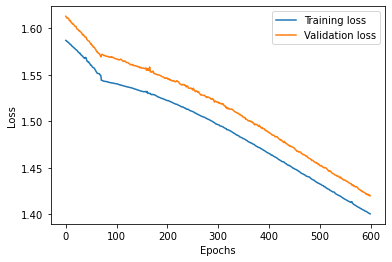

In [19]:
plt.figure()
plt.plot(e_three_scheduler_loss['losses'][400:], label='Training loss')
plt.plot(e_three_scheduler_loss['val_losses'][400:], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [26]:
data = get_data(["ANI-1_release/ani_gdb_s05.h5"])

ANI-1_release/ani_gdb_s05.h5


/global/homes/j/jamshedu/.local/perlmutter/pytorch1.9.0/lib/python3.8/site-packages/ANI1datatools/pyanitools.py:48: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.store = h5py.File(store_file)


## Based on the analysis above, it seems that the scheduler is working and is yielder smoother curves and is allowing the models to reach RMSE of ~1.3 for lr = 2e-4, after 1000 epochs. Thus for our final model with up to 5 heavy atoms we will attempt to use 2e-4 for 1000 epochs to attempt and reach RMSE of ~1.3.

# Tuning the number of batches with regularization and LR scheduler

In [13]:
@timing
def batch_optimization(batches):
    '''
    Function to evaluate effects of different batches on training time and errors
    '''
    batches_dict = {}
    for i in batches:
        training = create_model_input(train, i)
        validation = create_model_input(val, i)
        testing = create_model_input(test, i)

        batches_dict[i] = new_molecule_train_schedule(ANI(), training, validation, 2e-4, False, 1000, i)
    
    return batches_dict

cuda:0


  0%|          | 0/1000 [00:00<?, ?it/s]/global/common/software/nersc/shasta2105/pytorch/1.9.0/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:461.)
  return torch.floor_divide(self, other)


func:'new_molecule_train_schedule'  took: 1392.4537 sec
cuda:0


func:'new_molecule_train_schedule'  took: 800.6631 sec
cuda:0


func:'new_molecule_train_schedule'  took: 490.7121 sec
cuda:0


func:'new_molecule_train_schedule'  took: 351.5546 sec
cuda:0


func:'new_molecule_train_schedule'  took: 282.8287 sec
cuda:0


func:'new_molecule_train_schedule'  took: 247.1266 sec
func:'batch_optimization'  took: 3569.6559 sec


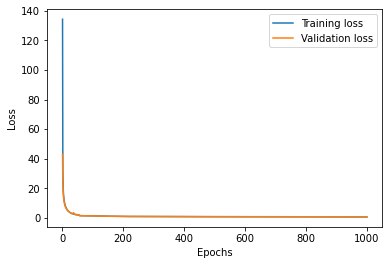

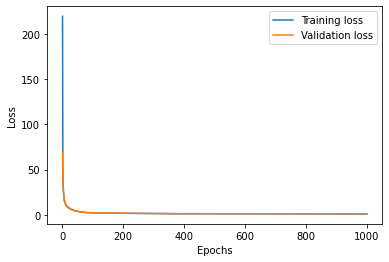

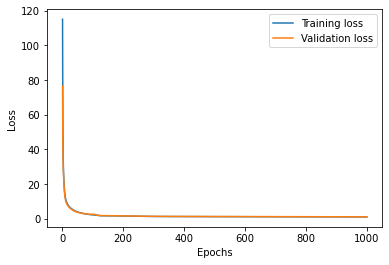

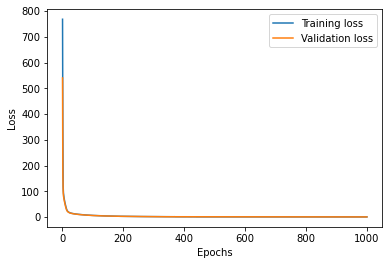

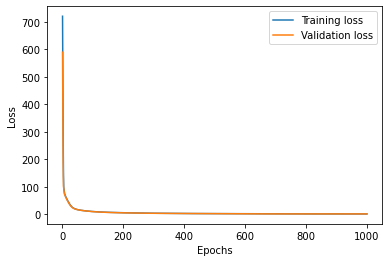

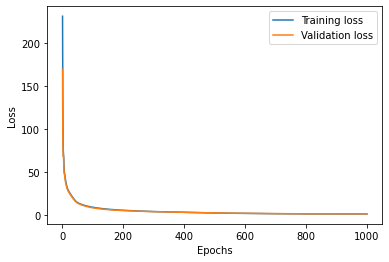

In [14]:
batch_results = batch_optimization([256, 512, 1024, 2048, 4096, 8192])

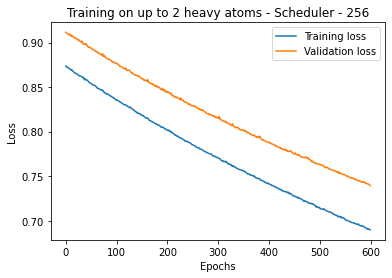

In [15]:
plt.figure()
plt.plot(batch_results[256]['losses'][400:], label='Training loss')
plt.plot(batch_results[256]['val_losses'][400:], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 2 heavy atoms - Scheduler - 256')
plt.savefig('2ha_2560_600_2e4_256_scheduler_zoomed.png')

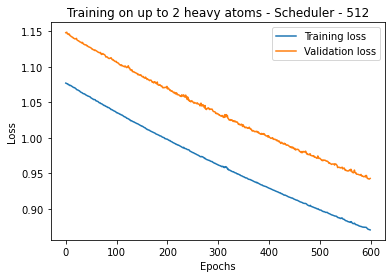

In [16]:
plt.figure()
plt.plot(batch_results[512]['losses'][400:], label='Training loss')
plt.plot(batch_results[512]['val_losses'][400:], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 2 heavy atoms - Scheduler - 512')
plt.savefig('2ha_2560_600_2e4_512_scheduler_zoomed.png')

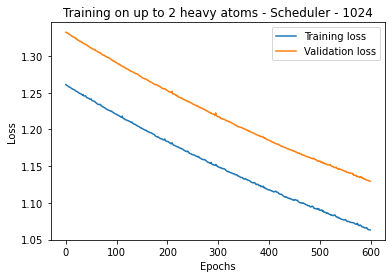

In [17]:
plt.figure()
plt.plot(batch_results[1024]['losses'][400:], label='Training loss')
plt.plot(batch_results[1024]['val_losses'][400:], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 2 heavy atoms - Scheduler - 1024')
plt.savefig('2ha_2560_600_2e4_1024_scheduler_zoomed.png')

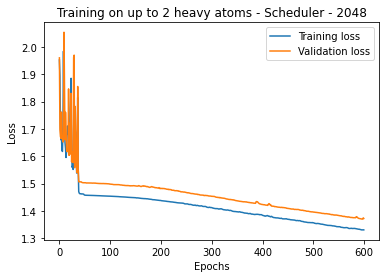

In [18]:
plt.figure()
plt.plot(batch_results[2048]['losses'][400:], label='Training loss')
plt.plot(batch_results[2048]['val_losses'][400:], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 2 heavy atoms - Scheduler - 2048')
plt.savefig('2ha_2560_600_2e4_2048_scheduler_zoomed.png')

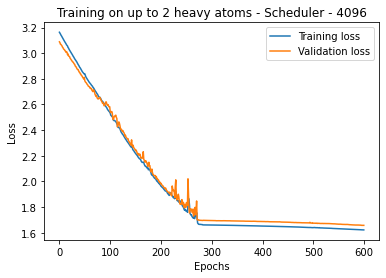

In [19]:
plt.figure()
plt.plot(batch_results[4096]['losses'][400:], label='Training loss')
plt.plot(batch_results[4096]['val_losses'][400:], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 2 heavy atoms - Scheduler - 4096')
plt.savefig('2ha_2560_600_2e4_4096_scheduler_zoomed.png')

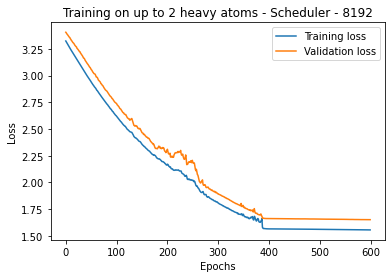

In [20]:
plt.figure()
plt.plot(batch_results[8192]['losses'][400:], label='Training loss')
plt.plot(batch_results[8192]['val_losses'][400:], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 2 heavy atoms - Scheduler - 8192')
plt.savefig('2ha_2560_600_2e4_8192_scheduler_zoomed.png')

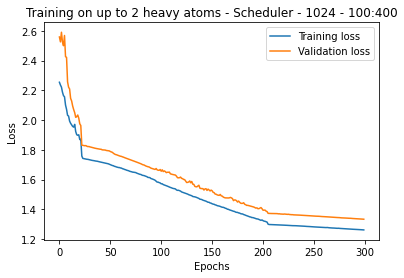

In [31]:
plt.figure()
plt.plot(batch_results[1024]['losses'][100:400], label='Training loss')
plt.plot(batch_results[1024]['val_losses'][100:400], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 2 heavy atoms - Scheduler - 1024 - 100:400')
plt.savefig('2ha_2560_600_2e4_1024_scheduler_zoomed_400_epochs.png')

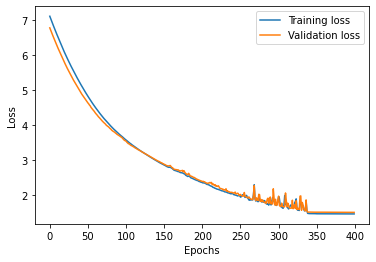

In [23]:
plt.figure()
plt.plot(batch_results[2048]['losses'][100:500], label='Training loss')
plt.plot(batch_results[2048]['val_losses'][100:500], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Summary of results comparing time taken to train and loss to batch size

In [56]:
batch_x = [256, 512, 1024, 2048, 4096, 8192]
time_x = [1392, 801, 490, 351, 283, 247]
val_error = [0.75, 0.95, 1.15, 1.41, 1.7, 1.7]
train_error = [0.7, 0.9, 1.06, 1.35, 1.6, 1.6]

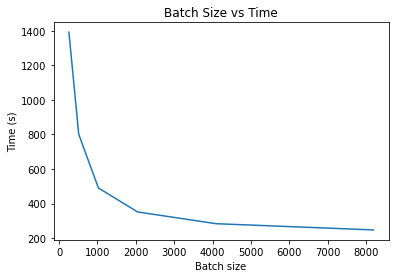

In [62]:
plt.figure()
plt.plot(batch_x, time_x)
plt.xlabel('Batch size')
plt.ylabel('Time (s)')
plt.title('Batch Size vs Time')
plt.savefig('Batch_Size_vs_Time.png')

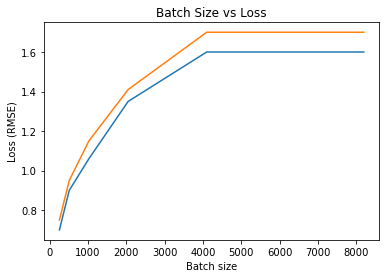

In [63]:
plt.figure()
plt.plot(batch_x, train_error, label='Training loss')
plt.plot(batch_x, val_error, label='Validation loss')
plt.xlabel('Batch size')
plt.ylabel('Loss (RMSE)')
plt.title('Batch Size vs Loss')
plt.savefig('Batch_Size_vs_Loss.png')

## Batch size seems to influence how fast training can be done as well as how smooth the curve looks. The lowest errors for all of these batches are comparable and around the same order of magnitude, however as the batch size increases, so does the loss. There seems to be a trade off between increasing batch size, training loss and time taken to train. Larger batch sizes lead to smoother curves, less time taken to train but comparably larger loss, while smaller batch sizes lead to comparably rougher curves, more time taken to train but smaller loss. As such a happy medium must be chosen where the batch size is not too large to cause larger loss but also large enough to train fast and yield a smoother curve. As such batch sizes of 1024 or 2048 fit this requirement. Moving forward with a batch size of 1024 to minimize loss, train quickly and yield a smoother curve. This will be particularly important when attempting to train on all molecules up to 5 heavy atoms which will take much longer than just training on all molecules up to 2 heavy atoms. At that time if training is taking much longer it may make sense to increase the batch size, because the total size of the data will also be much bigger.

# Final results of the best model based on hyper-parameter tuning

# Training on molecules up to 4 heavy atoms

In [19]:
data = get_data(["ANI-1_release/ani_gdb_s01.h5", "ANI-1_release/ani_gdb_s02.h5", "ANI-1_release/ani_gdb_s03.h5", "ANI-1_release/ani_gdb_s04.h5"])

ANI-1_release/ani_gdb_s01.h5
ANI-1_release/ani_gdb_s02.h5


/global/homes/j/jamshedu/.local/perlmutter/pytorch1.9.0/lib/python3.8/site-packages/ANI1datatools/pyanitools.py:48: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.store = h5py.File(store_file)


ANI-1_release/ani_gdb_s03.h5
ANI-1_release/ani_gdb_s04.h5


In [20]:
len(data)

864898

In [21]:
# Peform train_test_split on the data to get training, testing and validation sets
train, test = train_test_split(data, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.1, random_state=42)

In [22]:
training = create_model_input(train, 1024)
validation = create_model_input(val, 1024)
testing = create_model_input(test, 1024)

cuda:0


func:'new_molecule_train_schedule'  took: 2624.9284 sec


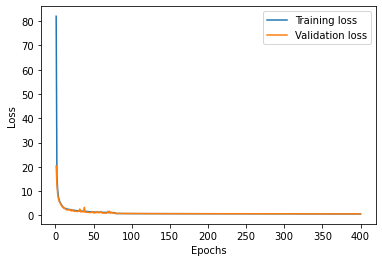

In [23]:
loss_log, test_log, final_model = new_molecule_train_schedule(ANI(), training, validation, testing, 2e-4, False, 400, 1024)

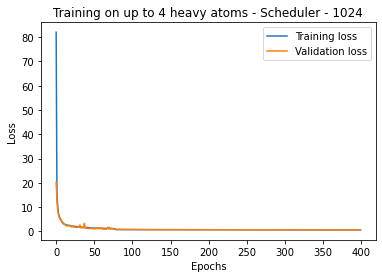

In [24]:
plt.figure()
plt.plot(loss_log['losses'], label='Training loss')
plt.plot(loss_log['val_losses'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 4 heavy atoms - Scheduler - 1024')
plt.savefig('4ha_400_2e4_1024_scheduler.png')

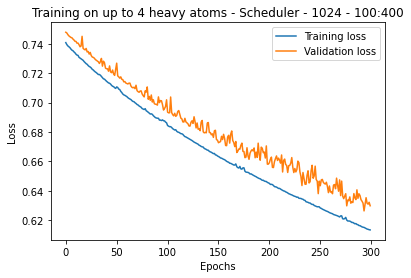

In [25]:
plt.figure()
plt.plot(loss_log['losses'][100:400], label='Training loss')
plt.plot(loss_log['val_losses'][100:400], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 4 heavy atoms - Scheduler - 1024 - 100:400')
plt.savefig('4ha_400_2e4_1024_scheduler_zoom.png')

In [26]:
test_log

0.6350928509563477

In [27]:
final_model

ANI(
  (sub_nets): ModuleDict(
    (0): ANI_sub(
      (layers): Sequential(
        (0): Linear(in_features=384, out_features=64, bias=True)
        (1): CELU(alpha=0.1)
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): CELU(alpha=0.1)
        (4): Linear(in_features=64, out_features=32, bias=True)
        (5): CELU(alpha=0.1)
        (6): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (1): ANI_sub(
      (layers): Sequential(
        (0): Linear(in_features=384, out_features=64, bias=True)
        (1): CELU(alpha=0.1)
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): CELU(alpha=0.1)
        (4): Linear(in_features=64, out_features=32, bias=True)
        (5): CELU(alpha=0.1)
        (6): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (2): ANI_sub(
      (layers): Sequential(
        (0): Linear(in_features=384, out_features=64, bias=True)
        (1): CELU(alpha=0.1)
        (2): Linear(in_

# Training on molecules up to 5 heavy atoms

In [43]:
data = get_data(["ANI-1_release/ani_gdb_s01.h5", "ANI-1_release/ani_gdb_s02.h5", "ANI-1_release/ani_gdb_s03.h5", "ANI-1_release/ani_gdb_s04.h5", "ANI-1_release/ani_gdb_s05.h5"])

ANI-1_release/ani_gdb_s01.h5
ANI-1_release/ani_gdb_s02.h5


/global/homes/j/jamshedu/.local/perlmutter/pytorch1.9.0/lib/python3.8/site-packages/ANI1datatools/pyanitools.py:48: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.store = h5py.File(store_file)


ANI-1_release/ani_gdb_s03.h5
ANI-1_release/ani_gdb_s04.h5
ANI-1_release/ani_gdb_s05.h5


In [44]:
len(data)

2678049

In [45]:
# Peform train_test_split on the data to get training, testing and validation sets
train, test = train_test_split(data, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.1, random_state=42)

In [46]:
training = create_model_input(train, 1024)
validation = create_model_input(val, 1024)
testing = create_model_input(test, 1024)

cuda:0


func:'new_molecule_train_schedule'  took: 9096.5412 sec


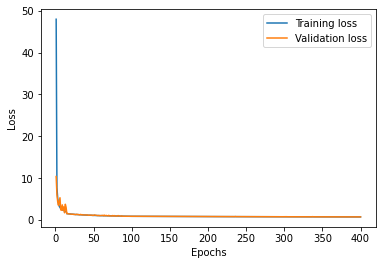

In [47]:
loss_log, test_log, final_model = new_molecule_train_schedule(ANI(), training, validation, testing, 2e-4, False, 400, 1024)

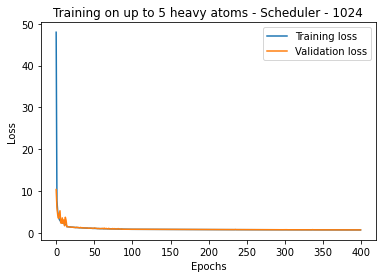

In [ ]:
plt.figure()
plt.plot(loss_log['losses'], label='Training loss')
plt.plot(loss_log['val_losses'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 5 heavy atoms - Scheduler - 1024')
plt.savefig('5ha_400_2e4_1024_scheduler.png')

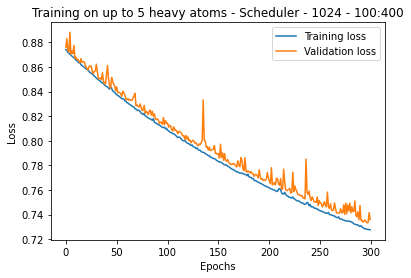

In [53]:
plt.figure()
plt.plot(loss_log['losses'][100:400], label='Training loss')
plt.plot(loss_log['val_losses'][100:400], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 5 heavy atoms - Scheduler - 1024 - 100:400')
plt.savefig('5ha_400_2e4_1024_scheduler_zoom.png')

In [54]:
test_log

0.7370875567296382

#  Training on molecules up to 6 heavy atoms

In [10]:
data = get_data(["ANI-1_release/ani_gdb_s01.h5", "ANI-1_release/ani_gdb_s02.h5", "ANI-1_release/ani_gdb_s03.h5", "ANI-1_release/ani_gdb_s04.h5", "ANI-1_release/ani_gdb_s05.h5", "ANI-1_release/ani_gdb_s06.h5"])

ANI-1_release/ani_gdb_s01.h5
ANI-1_release/ani_gdb_s02.h5


/global/homes/j/jamshedu/.local/perlmutter/pytorch1.9.0/lib/python3.8/site-packages/ANI1datatools/pyanitools.py:48: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.store = h5py.File(store_file)


ANI-1_release/ani_gdb_s03.h5
ANI-1_release/ani_gdb_s04.h5
ANI-1_release/ani_gdb_s05.h5
ANI-1_release/ani_gdb_s06.h5


In [11]:
len(data)

4360294

In [12]:
# Peform train_test_split on the data to get training, testing and validation sets
train, test = train_test_split(data, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.1, random_state=42)

In [13]:
training = create_model_input(train, 1024)
validation = create_model_input(val, 1024)
testing = create_model_input(test, 1024)

cuda:0


  0%|          | 0/400 [00:00<?, ?it/s]/global/common/software/nersc/shasta2105/pytorch/1.9.0/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:461.)
  return torch.floor_divide(self, other)


func:'new_molecule_train_schedule'  took: 14319.4249 sec


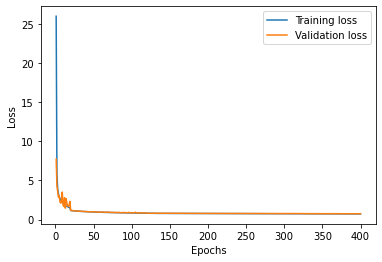

In [14]:
loss_log, test_log, final_model = new_molecule_train_schedule(ANI(), training, validation, testing, 2e-4, False, 400, 1024)

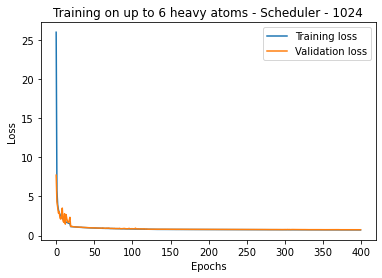

In [ ]:
plt.figure()
plt.plot(loss_log['losses'], label='Training loss')
plt.plot(loss_log['val_losses'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 6 heavy atoms - Scheduler - 1024')
plt.savefig('6ha_400_2e4_1024_scheduler.png')

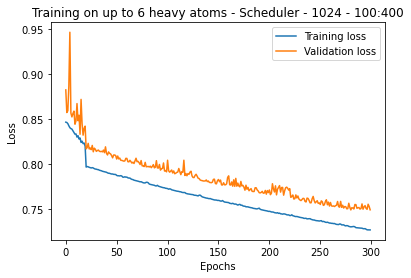

In [ ]:
plt.figure()
plt.plot(loss_log['losses'][100:400], label='Training loss')
plt.plot(loss_log['val_losses'][100:400], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training on up to 6 heavy atoms - Scheduler - 1024 - 100:400')
plt.savefig('6ha_400_2e4_1024_scheduler_zoom.png')

In [ ]:
test_log

0.7431752725969731

In [ ]:
final_model

ANI(
  (sub_nets): ModuleDict(
    (0): ANI_sub(
      (layers): Sequential(
        (0): Linear(in_features=384, out_features=64, bias=True)
        (1): CELU(alpha=0.1)
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): CELU(alpha=0.1)
        (4): Linear(in_features=64, out_features=32, bias=True)
        (5): CELU(alpha=0.1)
        (6): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (1): ANI_sub(
      (layers): Sequential(
        (0): Linear(in_features=384, out_features=64, bias=True)
        (1): CELU(alpha=0.1)
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): CELU(alpha=0.1)
        (4): Linear(in_features=64, out_features=32, bias=True)
        (5): CELU(alpha=0.1)
        (6): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (2): ANI_sub(
      (layers): Sequential(
        (0): Linear(in_features=384, out_features=64, bias=True)
        (1): CELU(alpha=0.1)
        (2): Linear(in_

In [21]:
num_model_params = sum(param.numel() for param in final_model.parameters())

In [22]:
num_model_params

123652

## The number of parameters in this model is 123652

# Conclusion Summary

## Overall I believe I have developed a model capable of predicting total potential energies for organic molecules containing up to 6 heavy atoms with a high degree of accuracy. My model performs better than the literature values of 1.2, 1.3, 1.3 RMSE for training, testing, and validation splits on up to 8 heavy atoms, however I am using less data (~20% of the data the paper used) and training for more epochs (4x as many epochs). However, if we examine the graphs for the 4-6 heavy atoms above, at around 100 epochs the error of my model is still lower than the literature values stated earlier which is an interesting result. This could indicate that I do not necessarily need to train for 400 epochs and could instead train for as long as the paper had trained (100 epochs), and this would speed up training significantly. The difference between my model and the literature are mainly the neural network, loss function, and scheduler. My neural network has the following hidden layers with the scheme of 384:64:64:32:1. My loss function is mean squared error and my scheduler starts with a learning rate of 2e-4 and reduces the learning rate upon plateau (5 epochs of no improvement) to a minimum learning rate of 3e-6. I believe this scheduler is a big reason why my error can get so low, because its just low enough to continue improving the model (the error becomes less smooth at later epochs but still trends downward). Areas for improvement would be to attempt to optimize the code further. The code is fairly optimized and was attempted to be written so that it was generalizable to different models/sub-network architectures, but there are potential places where optimization could take place such as improving the batch importance calculation for each batch. I would also like to attempt to train/test the model on up to 7 or 8 heavy atoms because I would like to see how the model would fare against the entire data set. I was unable to train on up to 7 heavy atoms because for 400 epochs, it would take ~10.5 hours and I usually get disconnected. However, it may be possible to run it for 100 epochs, based on the results from 4-6 heavy atoms it might be possible to have smaller loss than the paper.